In [1]:
import os

os.chdir("..")

print(os.getcwd())

c:\Users\mquick\Documents\zeitgeist blog\projects\political_fragmentation


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs
from utils import GiniCalculator

### Scrape and clean presidential election results data

* Presidential elections:
    * 2004
    * 2010
    * 2014
    * 2019
* Clean df schema:
    * Year
    * Region
    * Candidate name
    * Candidate votes (pct)
    * Candidate votes (total)
    * Total voters

#### Get list of region names and codes

In [3]:
url = "http://electionresources.org/ua/president.php?election=2019"
response = requests.get(url)
response.status_code

200

In [4]:
soup = bs(response.content)

In [5]:
regions_list = soup.find("select", {"name":"region"}).find_all("option")

In [6]:
regions_dict = {re.sub(r"\s{2,}", "", region.string): region["value"] for region in regions_list[1:]}

#### Extract election results data

In [7]:
BASE = "http://electionresources.org/ua/president.php?"

In [8]:
def parse_results_df(results_df: pd.DataFrame) -> list[dict]:
    results_no_missing = results_df.dropna()
    candidates_data = []
    is_candidate = True
    row_index = 0
    while is_candidate:
        row_index = row_index - 1
        candidate_name = results_no_missing.iloc[row_index, 0]
        candidate_votes = results_no_missing.iloc[row_index, 1]
        candidate_vote_pct = results_no_missing.iloc[row_index, 2]
        candidate_data = {
            "candidate_name": candidate_name,
            "candidate_votes": int(candidate_votes),
            "candidate_vote_pct": float(candidate_vote_pct),
            }
        candidates_data.append(candidate_data)
        is_candidate = results_no_missing.iloc[row_index-1, 0].lower() != "candidate"
    return candidates_data

In [9]:
elections = [2004, 2010, 2014, 2019]

In [10]:
results = []

for election in elections:
    for region_name, region_code in regions_dict.items():
        url = f"{BASE}election={election}&region={region_code}"
        try:
            tables = pd.read_html(url)
            region_results = tables[-1]
            candidates_data = parse_results_df(region_results)
            for candidate in candidates_data:
                candidate.update({"region_name": region_name, "election": election})
            results.extend(candidates_data)
        except:
            print(election, region_name)

2014 Autonomous Republic of Crimea
2014 City of Sevastopol
2019 Autonomous Republic of Crimea
2019 City of Sevastopol


In [11]:
results_df = pd.DataFrame(results)

### Calculate Gini coefficients

* Candidates by Gini score
* Elections by weighted average Gini score

In [12]:
calculator = GiniCalculator()

In [13]:
candidate_gini_scores_df = calculator.gini_coeff_by_candidate(results_df, 
                                                              candidates_col="candidate_name",
                                                              election_year_col="election",
                                                              votes_pct_col="candidate_vote_pct",
                                                              votes_total_col="candidate_votes"
                                                              )

#### By candidate

In [15]:
candidate_gini_scores_df["rank"] = candidate_gini_scores_df.groupby("election", as_index=False)["candidate_votes"].rank(ascending=False)

In [16]:
candidate_gini_scores_df["winner"] = candidate_gini_scores_df["rank"].apply(lambda x: 1 if x == 1 else 0)

In [17]:
candidate_gini_scores_df.head(3)

,election,candidate_name,gini_coeff,candidate_votes,rank,winner
0,2004,Viktor Yushchenko,0.163231,15054353,1.0,1
1,2004,Viktor Yanukovych,0.205064,12808839,2.0,0
2,2010,Yulia Tymoshenko,0.191033,11565983,2.0,0


In [18]:
candidate_gini_scores_df["candidate_name_year"] = candidate_gini_scores_df.apply(lambda x: f"{x['candidate_name']}, {x['election']}", axis=1)

<Axes: xlabel='gini_coeff', ylabel='candidate_name_year'>

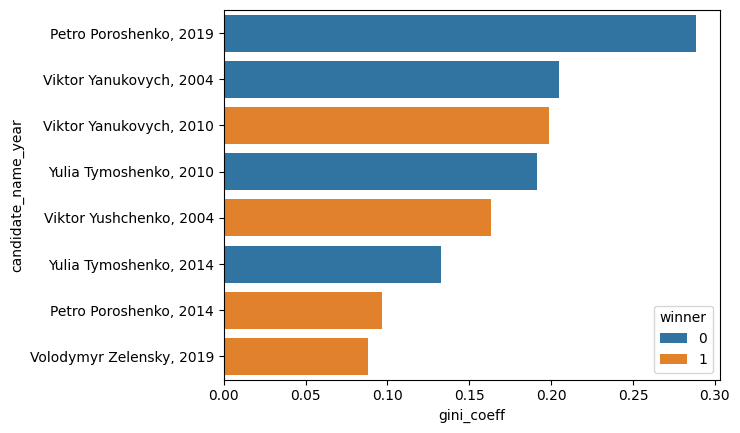

In [19]:
sns.barplot(data=candidate_gini_scores_df[candidate_gini_scores_df["rank"]<=2].sort_values("gini_coeff", ascending=False),
            x="gini_coeff",
            y="candidate_name_year",
            hue="winner"
            )

#### By election

In [20]:
election_gini_df = calculator.gini_coeff_by_election(candidate_gini_scores_df=candidate_gini_scores_df,
                                                     group_by_cols = ["election"],
                                                     votes_total_col = "candidate_votes"
                                                     )

<Axes: xlabel='election'>

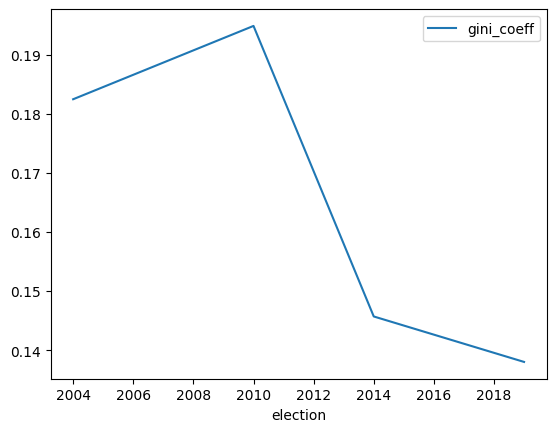

In [21]:
election_gini_df.plot.line(x="election", y="gini_coeff")